In [1]:
from engine import Value
from mlp import MLP, Layer, Neuron
import numpy as np
import random

In [2]:

# 5X5 image
image = [[4,5,4,4,4],
         [4,5,4,4,4],
         [4,5,4,4,4],
         [4,5,4,4,4],
         [4,5,4,4,4]]

print(image)

[[4, 5, 4, 4, 4], [4, 5, 4, 4, 4], [4, 5, 4, 4, 4], [4, 5, 4, 4, 4], [4, 5, 4, 4, 4]]


In [3]:
# 2X2 filter
filter = [[3,1],
          [4,5]]

print(filter)

[[3, 1], [4, 5]]


In [4]:
import time

def flatten(image, image_size):
    height = image_size
    width = image_size

    flat_array = []

    flat_array = [0]*(height*width)
    cnt = 0

    for i in range(height):
        for j in range(width):
            flat_array[cnt] = image[i][j]
            cnt += 1

    return flat_array

flatten(image, 5)

[4, 5, 4, 4, 4, 4, 5, 4, 4, 4, 4, 5, 4, 4, 4, 4, 5, 4, 4, 4, 4, 5, 4, 4, 4]

In [5]:
def mse_loss(ypred, y_train):
    return (ypred - y_train)**2

In [6]:
class MaxPool2d:
    def __init__(self, image_size, filter_size):
        self.image_size = image_size
        self.filter_size = filter_size
    
    def __call__(self, image):
        max_items = []
        final_image_size = self.image_size // 2
        final_image =  [[Value(0.0) for x in range(final_image_size)] for y in range(final_image_size)]
        
        for i in range(0, self.image_size, self.filter_size):
            for j in range(0, self.image_size, self.filter_size):
                max_item = Value(-1e9)
                for x in range(self.filter_size):
                    for y in range(self.filter_size):
                        max_item = max(Value(image[i+x][j+y]), max_item)
                max_items.append(max_item)
        
        idx = 0
        for a in range(final_image_size):
            for b in range(final_image_size):
                final_image[a][b] += max_items[idx]
                idx += 1        
        return final_image

# 4X4 image
image = [[4,6,4,3],
         [9,7,6,5],
         [1,7,8,2],
         [7,5,3,1]]

# image = [[Value(4),Value(6)],
#          [Value(9),Value(7)],]

max_pool = MaxPool2d(4,2)
max_pool(image)

[[Value(data=9.0), Value(data=6.0)], [Value(data=7.0), Value(data=8.0)]]

In [7]:
class Conv2d:
    def __init__(self, image_size, filter_size):
        self.image_size = image_size
        self.filter_size = filter_size
        self.filter = [[Value(random.uniform(-1,1), label='conv') for _ in range(filter_size)] for _ in range(filter_size)]

    def __call__(self, image):
        final_image_size = int(self.image_size - self.filter_size + 1)
        # print(final_image_size, type(final_image_size))
        final_image = np.zeros([final_image_size, final_image_size])
        final_image = [[Value(0.0) for x in range(final_image_size)] for y in range(final_image_size)] 
        
        for i in range(final_image_size):
            for j in range(final_image_size):
                
                for x in range(self.filter_size):
                    for y in range(self.filter_size):

                        if i+x < self.image_size and j+y < self.image_size:
                            final_image[i][j] += (image[i+x][j+y] * self.filter[x][y])

        return final_image
    
    def parameters(self):
        # print(self.filter)
        o = flatten(self.filter, self.filter_size)
        # all_grads = [x.grad for x in o]
        # print(all_grads)
        return o

# conv(image, 5, filter, 2)

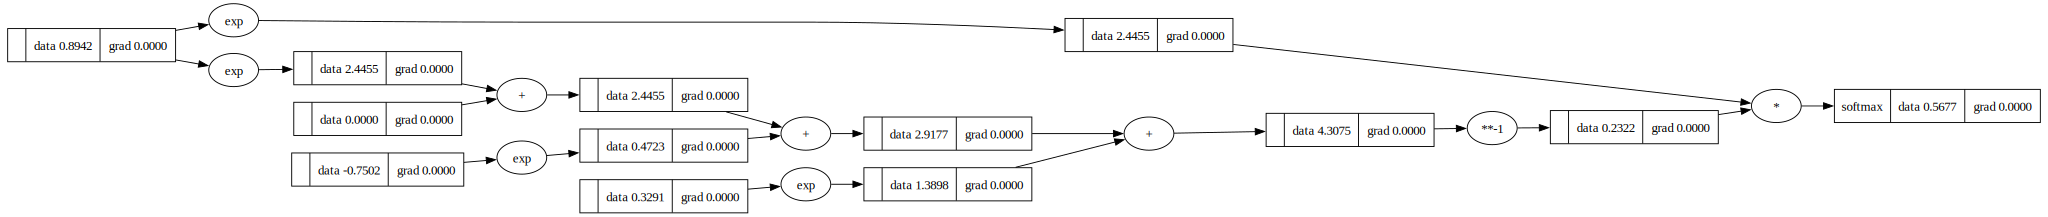

In [8]:
import math

def softmax(logits):
    outputs = []

    denominator = Value(0)

    for logit in logits:
        denominator += logit.exp()

    for logit in logits:
        softmax_score = logit.exp() / denominator
        softmax_score.label = 'softmax'
        outputs.append(softmax_score)

    # logits = outputs
    
    return outputs

l = softmax([Value(data=0.8942415841754484), 
         Value(data=-0.7502373687945066), 
         Value(data=0.32914364144553077)]
)

from utils import draw_dot
draw_dot(l[0])

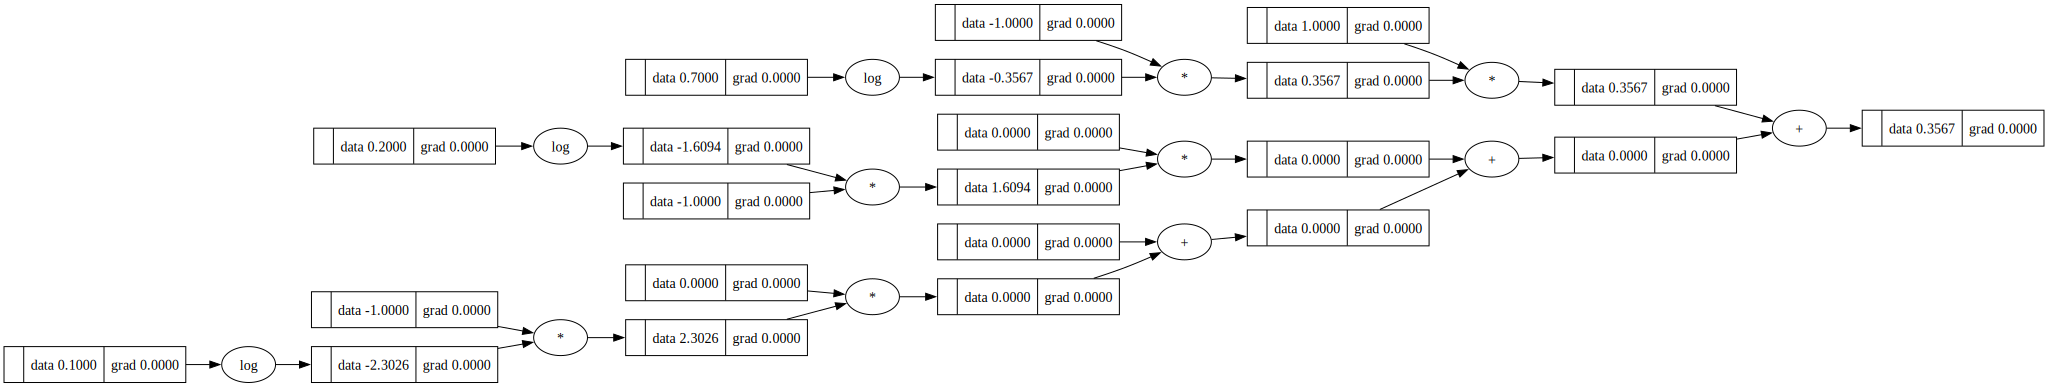

In [34]:
def cross_entropy_loss(logits, true_labels):
    """
    logits should be list of Value objects ... 
    assuming logits are prob values from softmax
    
    returns cross_entropy_loss as a Value object
    """
    loss = Value(0)

    for i in range(len(logits)):
            loss += -1 * logits[i].log() * true_labels[i]

    return loss

l = cross_entropy_loss(logits=[Value(0.1),Value(0.2),Value(0.7)], true_labels=[0,0,1])
from utils import draw_dot
draw_dot(l)

In [40]:
import torch.nn as nn
import torch.nn.functional as F

# net = Net()

class CNN:
    def __init__(self, output_layers):
        self.conv1 = Conv2d(5, 2)
        self.max_pool = MaxPool2d(4,2)
        self.fc = MLP(4, [2, 2, output_layers])
    
    def __call__(self, input_image):
        outputs = self.conv1(input_image)
        outputs = self.max_pool(outputs)
        # print(outputs)
        outputs = flatten(outputs, 2)

        t = []
        for i in outputs:
            t.append(i.data)
        
        outputs = self.fc(t)
        return outputs
    
    def parameters(self):
        # print(self.conv1.parameters())
        return self.fc.parameters() + self.conv1.parameters()

In [41]:
image = [[1,0,1,1,0],
         [1,0,0,1,0],
         [1,0,1,1,0],
         [1,0,0,1,0],
         [1,0,1,1,0]]

labels = [1, 0, 0]
label = [1]

cnn_model = CNN(3)

for i in range(10):
    
    #forward
    outputs = cnn_model(image)
    outputs = softmax(outputs)

    # loss = mse_loss(outputs, label)
    loss = cross_entropy_loss(outputs, labels)
    # print(loss.grad)

    # zero_grad
    for p in cnn_model.parameters():
        p.grad = 0.0

    loss.backward()

    # update
    for p in cnn_model.parameters():
        p.data += -0.01 * p.grad

    if i%1 == 0:
        print(f"Epoch {i}, Loss: {loss.data}")

Epoch 0, Loss: 0.480480190216179
Epoch 1, Loss: 0.47695421043927605
Epoch 2, Loss: 0.47347282211410696
Epoch 3, Loss: 0.4700354088888726
Epoch 4, Loss: 0.46664139368995783
Epoch 5, Loss: 0.4632902381272765
Epoch 6, Loss: 0.4599814416535266
Epoch 7, Loss: 0.45671454049682564
Epoch 8, Loss: 0.4534891063862768
Epoch 9, Loss: 0.4503047450900492


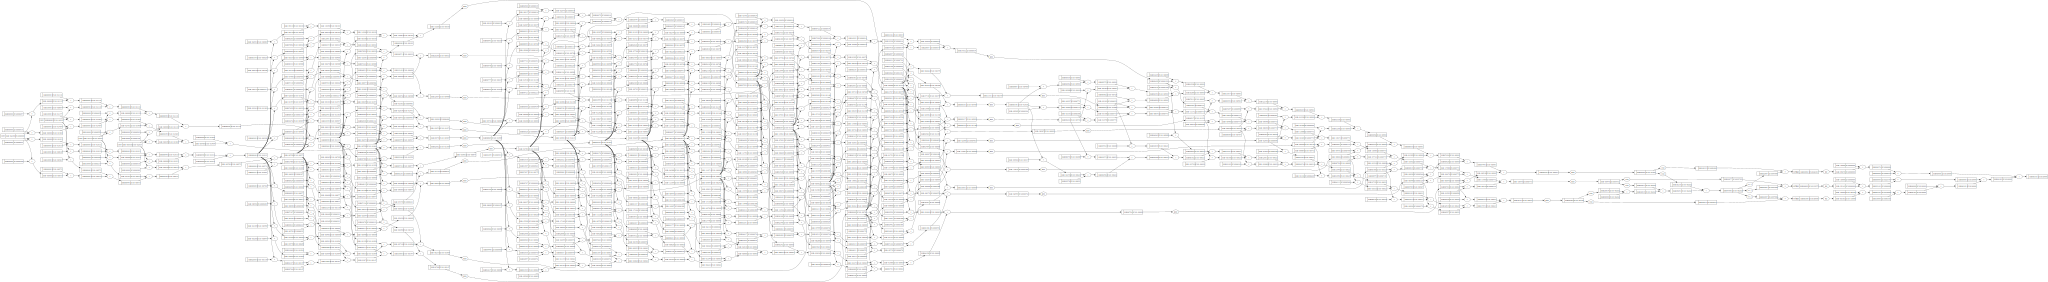

In [37]:
from utils import draw_dot
draw_dot(loss)


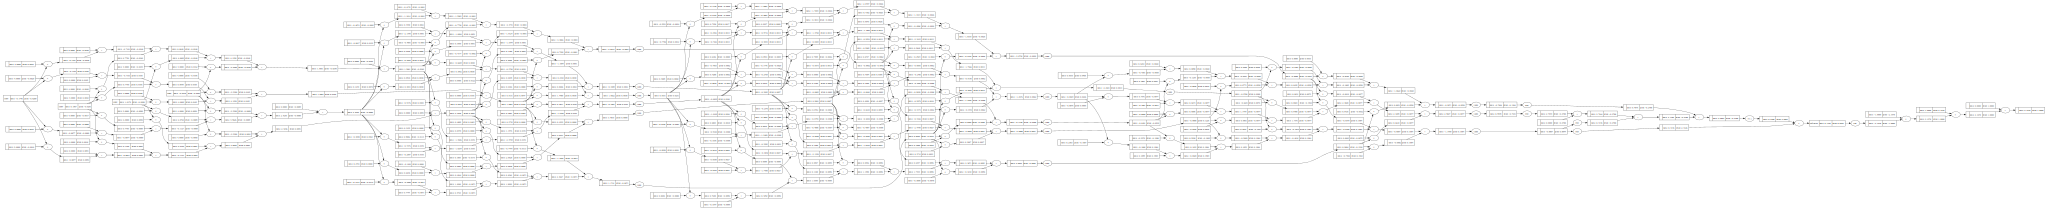

In [13]:
from utils import draw_dot
draw_dot(loss)